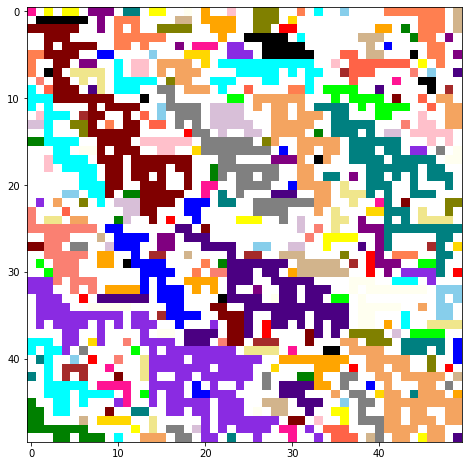

In [8]:
import sys
import time
import numpy as np
import pylab as plb
import matplotlib

plb.rcParams['figure.figsize'] = 8,8



SIZE = 50

#Change Pvals in a interval to get datas
pvals = np.array([0.58])
#pvals = np.linspace(0.3,0.4,num=4)
#pvals = np.append(pvals,np.linspace(0.41,0.81,num=20))
#pvals = np.append(pvals,np.linspace(0.82,0.9,num=4))
d = 1
Xs = []
Ys = []

def Where_It_Points(L,x):
    while L[x] != x:
        x = L[x]
    return L[x]


def Perculated(net,L):
    dim = net.shape[0]
    A = set([net[i,0] for i in range(dim)])
    B = set([net[i,dim-1] for i in range(dim)])
    A.discard(0)
    B.discard(0)
    A = np.array(list(A))
    B = np.array(list(B))
    dimA , dimB = A.shape[0],B.shape[0]
    for s in range(dimA):
        A[s] = Where_It_Points(L,A[s])
    for k in range(dimB):
        B[k] = Where_It_Points(L,B[k])   
    if len(np.intersect1d(A,B)):
        return True
    return False


#Let's Do it
def Rearrange_Matrix(Mat,L):

    non0 = np.count_nonzero(L)
    Coupling_color_List = [[] for s in range(non0+1)]

    for i,color in enumerate(L.tolist()):
        if not color:
            continue
        if L[i] == i:          #if L[i] == color:
            Coupling_color_List[i].append(color)
        else:
            for k in range(non0):
                if color in Coupling_color_List[k+1]:
                    Coupling_color_List[k+1].append(i)
                    break
            else:
                Coupling_color_List[i].append(i)
                Coupling_color_List[i].append(color)
    #print(Coupling_color_List)
    
    while [] in Coupling_color_List:
        Coupling_color_List.remove([])
    non0 = len(Coupling_color_List)
    
    for w in range(non0):
        for t in range(non0):
            A = set(Coupling_color_List[t])
            B = set(Coupling_color_List[w])
            if A & B and w != t:
                #print(w,t)
                C = A | B
                Coupling_color_List.remove(Coupling_color_List[t])
                Coupling_color_List.insert(t,list(C))
                Coupling_color_List.remove(Coupling_color_List[w])
                Coupling_color_List.insert(w,[])
    #print(Coupling_color_List)
    for elem in Coupling_color_List: 
        if elem:
            for j in elem:
                Mat[Mat == j] = min(elem)
    return Mat



#Hoshen kopelman
for p in pvals:
    prob_c = 0
    for _ in range(d):
        C = 1
        L = np.zeros((SIZE*SIZE//2+1,),'int64')
        S = np.zeros(SIZE*SIZE//2+1,'int64')
        Island_Matrix = np.zeros((SIZE,SIZE),'int32')
        net = np.random.rand(SIZE,SIZE)
        net[net > p] = 0
        net[net != 0] = 1
        net = net.astype('int8')

        for j in range(SIZE):
            for i in range(SIZE):
                if net[i,j]:
                    #print(i,j)
                    if i == 0:
                        if j == 0:
                            Island_Matrix[i,j] = C
                            L[C] = C
                            S[C] +=1
                            C+=1
                        elif net[i,j-1]:
                            Island_Matrix[i,j] = Island_Matrix[i,j-1]
                            S[L[Island_Matrix[i,j-1]]] +=1
                        else:
                            Island_Matrix[i,j] = C
                            L[C] = C
                            S[C] +=1
                            C+=1
                    elif j == 0:
                        if net[i-1,j]:
                            Island_Matrix[i,j] = Island_Matrix[i-1,j]
                            S[L[Island_Matrix[i-1,j]]] +=1
                        else:
                            Island_Matrix[i,j] = C
                            L[C] = C
                            S[C] +=1
                            C+=1
                    else:
                        Min = min({Island_Matrix[i-1,j],Island_Matrix[i,j-1]})
                        Max = max({Island_Matrix[i-1,j],Island_Matrix[i,j-1]})
                        MinRef = Where_It_Points(L,Min)
                        MaxRef = Where_It_Points(L,Max)
                        if Max == 0:
                            Island_Matrix[i,j] = C
                            L[C] = C
                            S[C] +=1
                            C+=1

                        elif not Min and Max:
                            Island_Matrix[i,j] = Max
                            S[L[MaxRef]] +=1

                        elif Max == Min:
                            Island_Matrix[i,j] = Max
                            S[L[MaxRef]] +=1

                        elif Max != Min:

                            MinRef = Where_It_Points(L,Min)
                            MaxRef = Where_It_Points(L,Max)

                            Island_Matrix[i,j] = Min
                            if L[MaxRef] != L[MinRef]:
                                S[L[MinRef]] += S[L[MaxRef]]
                                L[MaxRef] = L[MinRef]
                            S[L[MinRef]] +=1

        #Island_Matrix = Rearrange_Matrix(Island_Matrix,L)
        if (Perculated(Island_Matrix,L)):
            prob_c+=1

    Xs.append(p)
    Ys.append(prob_c/d)
    
    
    
np.set_printoptions(threshold=sys.maxsize)            
cmap = matplotlib.colors.ListedColormap(['white',"black",'skyblue','tan','thistle','teal','sandybrown','red','coral','blueviolet','khaki','ivory','deeppink','salmon','tomato','purple','orange','green','yellow','grey','blue','cyan','lime','olive','gold','maroon','pink','brown','indigo']*119)

#Reindex Islands
#Island_Matrix = Rearrange_Matrix(Island_Matrix,L)
plb.imshow(Island_Matrix,cmap=cmap)
